# RNN

In [2]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pickle
import tensorflow as tf
import keras

In [4]:
# load numpy array from npy file
from numpy import load
# load array
X_train = load('x_train.npy')
y_train = load('y_train.npy')
y_test = load('y_test.npy')
x_test = load('x_test.npy')

In [12]:
X_train = X_train.reshape(X_train.shape[0],240,320*3)
x_test = x_test.reshape(x_test.shape[0],240,320*3)

In [13]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [14]:
np.random.shuffle(X_train)
np.random.shuffle(y_train_one_hot)

## Build the model

In [15]:
# define the class weight becuase the two classes are not even

class_weight = {0: 1, 1: 2.7}

In [16]:
# define the model

model = Sequential()
model.add(LSTM(256,dropout=0.2,input_shape=(X_train.shape[1],X_train.shape[2])))

# dense layer for classification
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5)) # dropout layer helps with overfitting
model.add(Dense(2, activation='softmax')) # final layer eight classes output
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               1246208   
_________________________________________________________________
dense (Dense)                (None, 1024)              263168    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 1,511,426
Trainable params: 1,511,426
Non-trainable params: 0
_________________________________________________________________


In [17]:
# optimizer 

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              weighted_metrics=['accuracy'])

In [20]:
# define a callback list 

my_callbacks = [
    
    # stop if val_loss has no improvement for 4 epochs
    tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True,monitor='val_accuracy'),
    
    # save the model after each epoch, monitor the val_acc for max value, save only the best weights
    tf.keras.callbacks.ModelCheckpoint(filepath='checkpoints/rnn_checkpoint.h5',monitor='val_acc',
                                      save_best_only=True,mode='max',save_freq='epoch'),
    
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [19]:
hist=model.fit(X_train,y_train_one_hot,validation_split=0.2,verbose=1,epochs=20,callbacks=my_callbacks,
                        shuffle=True,class_weight=class_weight, batch_size=32)

Epoch 1/10
   1/1651 [..............................] - ETA: 0s - loss: 1.0706 - accuracy: 0.5694WARNING:tensorflow:From C:\Users\bebbi\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1651/1651 [==============================] - 2656s 2s/step - loss: 1.0006 - accuracy: 0.5110 - val_loss: 0.6786 - val_accuracy: 0.6040
Epoch 2/10
1651/1651 [==============================] - 2715s 2s/step - loss: 0.9935 - accuracy: 0.5145 - val_loss: 0.6774 - val_accuracy: 0.7329
Epoch 3/10
1651/1651 [==============================] - 2609s 2s/step - loss: 0.9937 - accuracy: 0.5188 - val_loss: 0.6699 - val_accuracy: 0.7346
Epoch 4/10
1651/1651 [==============================] - 2572s 2s/step - loss: 0.9939 - accuracy: 0.5205 - val_loss: 0.6881 - val_accuracy: 0.5991
Epoch 5/10
1651/1651 [========

In [21]:
# save the model 

model.save('models/rnn.h5')

## Model Visualization

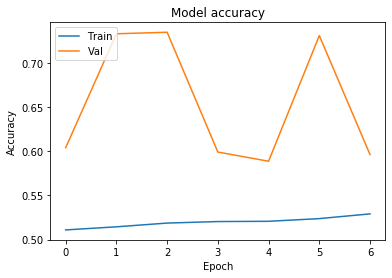

In [22]:
#Visualize the models accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

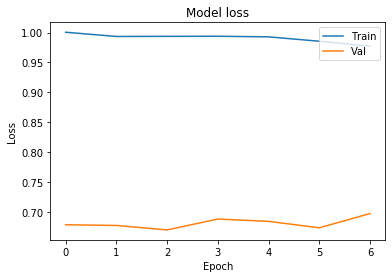

In [23]:
#Visualize the models loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## Testing

In [24]:
print("Model Accuracy: ",model.evaluate(x_test, y_test_one_hot)[1])
print("Model Loss: ",model.evaluate(x_test, y_test_one_hot)[0])

575/575 [==============================] - 336s 584ms/step - loss: 0.6656 - accuracy: 0.7385
Model Accuracy:  0.7384724020957947
575/575 [==============================] - 319s 556ms/step - loss: 0.6656 - accuracy: 0.7385
Model Loss:  0.6656085252761841


## Demo

In [27]:
from sklearn.preprocessing import LabelBinarizer

y_train = np.load('y_train.npy')

y_test = np.load('y_test.npy')

total_labels = np.concatenate((y_train, y_test), axis=0)
labelbin = LabelBinarizer()
lb = labelbin.fit_transform(total_labels)

In [28]:
from collections import deque
import cv2

# open the video file to classify
capture = cv2.VideoCapture(r"Anomaly_Dataset\Anomaly_Detection\test\Crime\Assault011_x264.mp4")
width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))   # float
height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)) # float
Queue = deque(maxlen=180)
writer = None

In [ ]:
# loop over frames from the video file stream
while True:
    
    # read the next frame from the file
    (grabbed, frame) = capture.read()

    # if the frame was not grabbed, then we have reached the end of the stream
    if not grabbed:
        break


    # clone the output frame # ordering, resize the frame to a fixed 224x224, and then perform mean subtraction
    output = frame.copy()
    frame = cv2.resize(frame,(960,240))
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY )
    
    # make predictions on the frame and then update the predictions queue
    preds = model.predict(np.expand_dims(frame, axis=0))
    Queue.append(preds)

    # perform prediction averaging over the current history of previous predictions
    results = np.array(Queue).mean(axis=0)
    i = np.argmax(results)
    label = labelbin.classes_[i]
    
    # draw the activity on the output frame
    if label ==0:
        text = "Crime Detected"
    if label ==1:
        text = "No Crime Detected"
        
    cv2.putText(output, text, (25, 20), cv2.FONT_HERSHEY_SIMPLEX,1, (0, 255, 0), 2)

    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        writer = cv2.VideoWriter("output_3dcnn.avi", fourcc, 30,(width, height))

    # write the output frame to disk
    writer.write(output)

    # show the output image
    cv2.imshow("Output", output)
    key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

# release the file pointers
writer.release()
capture.release()
cv2.destroyAllWindows()